In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer

In [2]:
afq_dataset = AFQDataset(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md"],
    target_cols=["age"],
    index_col="subject_id",
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1867
(1867, 4800)
(1867,)


In [5]:
# Here we impute missing bundles.
# We impute using the entire dataset, which permits data leakage between the train and test set.
# THIS IS BAD AND SHOULDN'T BE DONE IN PRODUCTION
# But we do it here to move straight to model training
# When we are more comfortabel with the models, we should come back
# here and train the imputer only on the training set.
imputer = SimpleImputer(strategy="median")
afq_dataset.X = imputer.fit_transform(afq_dataset.X)

In [6]:
# Separate into training, test, and validation sets
dataset_size = len(afq_dataset.subjects)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

full_dataset = afq_dataset.as_tensorflow_dataset()
full_dataset = full_dataset.shuffle(buffer_size=dataset_size, seed=0)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

2022-02-08 18:56:25.232251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# import tensorflow_datasets as tfds
# tfds.as_numpy(val_dataset)

In [9]:
batch_size = 128
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [33]:
# First let's check out the ``cnn_lenet`` from the tf_models module
model_cnn_lenet= cnn_lenet(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)

# Compile the model and fit it using training data
model_cnn_lenet.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_lenet = model_cnn_lenet.fit(train_dataset, epochs=2000, validation_data=val_dataset)

pooling layers: 4
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 conv1d_22 (Conv1D)          (None, 100, 6)            870       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 50, 6)            0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 50, 16)            304       
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 25, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 25, 2

Epoch 34/2000
11/11 [==============================] - 0s 37ms/step - loss: 15.8500 - mean_squared_error: 15.8500 - val_loss: 12.9622 - val_mean_squared_error: 12.9622
Epoch 35/2000
11/11 [==============================] - 0s 36ms/step - loss: 15.8256 - mean_squared_error: 15.8256 - val_loss: 11.5952 - val_mean_squared_error: 11.5952
Epoch 36/2000
11/11 [==============================] - 0s 38ms/step - loss: 16.3604 - mean_squared_error: 16.3604 - val_loss: 12.3654 - val_mean_squared_error: 12.3654
Epoch 37/2000
11/11 [==============================] - 0s 39ms/step - loss: 15.2421 - mean_squared_error: 15.2421 - val_loss: 12.8075 - val_mean_squared_error: 12.8075
Epoch 38/2000
11/11 [==============================] - 0s 43ms/step - loss: 16.3314 - mean_squared_error: 16.3314 - val_loss: 11.1596 - val_mean_squared_error: 11.1596
Epoch 39/2000
11/11 [==============================] - 0s 37ms/step - loss: 15.8491 - mean_squared_error: 15.8491 - val_loss: 10.3930 - val_mean_squared_error: 

11/11 [==============================] - 0s 35ms/step - loss: 10.4387 - mean_squared_error: 10.4387 - val_loss: 7.8775 - val_mean_squared_error: 7.8775
Epoch 133/2000
11/11 [==============================] - 0s 40ms/step - loss: 10.9744 - mean_squared_error: 10.9744 - val_loss: 6.9076 - val_mean_squared_error: 6.9076
Epoch 134/2000
11/11 [==============================] - 0s 40ms/step - loss: 11.0211 - mean_squared_error: 11.0211 - val_loss: 7.2106 - val_mean_squared_error: 7.2106
Epoch 135/2000
11/11 [==============================] - 0s 44ms/step - loss: 9.5482 - mean_squared_error: 9.5482 - val_loss: 7.2362 - val_mean_squared_error: 7.2362
Epoch 136/2000
11/11 [==============================] - 0s 41ms/step - loss: 10.5903 - mean_squared_error: 10.5903 - val_loss: 7.1534 - val_mean_squared_error: 7.1534
Epoch 137/2000
11/11 [==============================] - 0s 41ms/step - loss: 10.3460 - mean_squared_error: 10.3460 - val_loss: 6.7997 - val_mean_squared_error: 6.7997
Epoch 138/2000


Epoch 231/2000
11/11 [==============================] - 0s 35ms/step - loss: 8.3021 - mean_squared_error: 8.3021 - val_loss: 6.3893 - val_mean_squared_error: 6.3893
Epoch 232/2000
11/11 [==============================] - 0s 35ms/step - loss: 8.0931 - mean_squared_error: 8.0931 - val_loss: 5.6491 - val_mean_squared_error: 5.6491
Epoch 233/2000
11/11 [==============================] - 0s 42ms/step - loss: 8.2647 - mean_squared_error: 8.2647 - val_loss: 6.1867 - val_mean_squared_error: 6.1867
Epoch 234/2000
11/11 [==============================] - 0s 38ms/step - loss: 8.1979 - mean_squared_error: 8.1979 - val_loss: 6.1923 - val_mean_squared_error: 6.1923
Epoch 235/2000
11/11 [==============================] - 0s 42ms/step - loss: 8.9048 - mean_squared_error: 8.9048 - val_loss: 6.1534 - val_mean_squared_error: 6.1534
Epoch 236/2000
11/11 [==============================] - 1s 48ms/step - loss: 8.4124 - mean_squared_error: 8.4124 - val_loss: 7.1437 - val_mean_squared_error: 7.1437
Epoch 237/

Epoch 281/2000
11/11 [==============================] - 0s 35ms/step - loss: 8.0141 - mean_squared_error: 8.0141 - val_loss: 4.5958 - val_mean_squared_error: 4.5958
Epoch 282/2000
11/11 [==============================] - 0s 38ms/step - loss: 7.8520 - mean_squared_error: 7.8520 - val_loss: 5.5844 - val_mean_squared_error: 5.5844
Epoch 283/2000
11/11 [==============================] - 0s 42ms/step - loss: 8.1159 - mean_squared_error: 8.1159 - val_loss: 4.6613 - val_mean_squared_error: 4.6613
Epoch 284/2000
11/11 [==============================] - 0s 39ms/step - loss: 8.1566 - mean_squared_error: 8.1566 - val_loss: 5.1241 - val_mean_squared_error: 5.1241
Epoch 285/2000
11/11 [==============================] - 0s 40ms/step - loss: 7.4621 - mean_squared_error: 7.4621 - val_loss: 5.0208 - val_mean_squared_error: 5.0208
Epoch 286/2000
11/11 [==============================] - 0s 34ms/step - loss: 7.7594 - mean_squared_error: 7.7594 - val_loss: 5.6047 - val_mean_squared_error: 5.6047
Epoch 287/

Epoch 331/2000
11/11 [==============================] - 0s 35ms/step - loss: 8.1868 - mean_squared_error: 8.1868 - val_loss: 6.5310 - val_mean_squared_error: 6.5310
Epoch 332/2000
11/11 [==============================] - 0s 36ms/step - loss: 7.9946 - mean_squared_error: 7.9946 - val_loss: 6.0807 - val_mean_squared_error: 6.0807
Epoch 333/2000
11/11 [==============================] - 0s 38ms/step - loss: 7.6473 - mean_squared_error: 7.6473 - val_loss: 5.2785 - val_mean_squared_error: 5.2785
Epoch 334/2000
11/11 [==============================] - 0s 42ms/step - loss: 7.3880 - mean_squared_error: 7.3880 - val_loss: 6.7118 - val_mean_squared_error: 6.7118
Epoch 335/2000
11/11 [==============================] - 0s 37ms/step - loss: 7.5776 - mean_squared_error: 7.5776 - val_loss: 4.9857 - val_mean_squared_error: 4.9857
Epoch 336/2000
11/11 [==============================] - 0s 38ms/step - loss: 7.2307 - mean_squared_error: 7.2307 - val_loss: 5.0562 - val_mean_squared_error: 5.0562
Epoch 337/

Epoch 381/2000
11/11 [==============================] - 0s 38ms/step - loss: 6.6939 - mean_squared_error: 6.6939 - val_loss: 4.6024 - val_mean_squared_error: 4.6024
Epoch 382/2000
11/11 [==============================] - 0s 43ms/step - loss: 7.3513 - mean_squared_error: 7.3513 - val_loss: 4.8597 - val_mean_squared_error: 4.8597
Epoch 383/2000
11/11 [==============================] - 0s 39ms/step - loss: 7.4292 - mean_squared_error: 7.4292 - val_loss: 5.0853 - val_mean_squared_error: 5.0853
Epoch 384/2000
11/11 [==============================] - 0s 44ms/step - loss: 6.9155 - mean_squared_error: 6.9155 - val_loss: 4.4776 - val_mean_squared_error: 4.4776
Epoch 385/2000
11/11 [==============================] - 0s 41ms/step - loss: 7.2619 - mean_squared_error: 7.2619 - val_loss: 4.6609 - val_mean_squared_error: 4.6609
Epoch 386/2000
11/11 [==============================] - 0s 44ms/step - loss: 7.3120 - mean_squared_error: 7.3120 - val_loss: 4.7207 - val_mean_squared_error: 4.7207
Epoch 387/

Epoch 431/2000
11/11 [==============================] - 0s 36ms/step - loss: 6.9064 - mean_squared_error: 6.9064 - val_loss: 4.6317 - val_mean_squared_error: 4.6317
Epoch 432/2000
11/11 [==============================] - 0s 37ms/step - loss: 6.5600 - mean_squared_error: 6.5600 - val_loss: 4.6584 - val_mean_squared_error: 4.6584
Epoch 433/2000
11/11 [==============================] - 0s 41ms/step - loss: 6.8391 - mean_squared_error: 6.8391 - val_loss: 4.6695 - val_mean_squared_error: 4.6695
Epoch 434/2000
11/11 [==============================] - 0s 41ms/step - loss: 7.1382 - mean_squared_error: 7.1382 - val_loss: 4.6317 - val_mean_squared_error: 4.6317
Epoch 435/2000
11/11 [==============================] - 0s 39ms/step - loss: 6.9008 - mean_squared_error: 6.9008 - val_loss: 5.2640 - val_mean_squared_error: 5.2640
Epoch 436/2000
11/11 [==============================] - 0s 38ms/step - loss: 7.6481 - mean_squared_error: 7.6481 - val_loss: 5.3875 - val_mean_squared_error: 5.3875
Epoch 437/

Epoch 481/2000
11/11 [==============================] - 0s 37ms/step - loss: 6.5396 - mean_squared_error: 6.5396 - val_loss: 4.4064 - val_mean_squared_error: 4.4064
Epoch 482/2000
11/11 [==============================] - 0s 39ms/step - loss: 6.6581 - mean_squared_error: 6.6581 - val_loss: 4.4391 - val_mean_squared_error: 4.4391
Epoch 483/2000
11/11 [==============================] - 0s 41ms/step - loss: 6.3999 - mean_squared_error: 6.3999 - val_loss: 4.1791 - val_mean_squared_error: 4.1791
Epoch 484/2000
11/11 [==============================] - 0s 41ms/step - loss: 6.8973 - mean_squared_error: 6.8973 - val_loss: 4.9168 - val_mean_squared_error: 4.9168
Epoch 485/2000
11/11 [==============================] - 0s 37ms/step - loss: 6.5977 - mean_squared_error: 6.5977 - val_loss: 4.4002 - val_mean_squared_error: 4.4002
Epoch 486/2000
11/11 [==============================] - 0s 38ms/step - loss: 6.5194 - mean_squared_error: 6.5194 - val_loss: 4.4705 - val_mean_squared_error: 4.4705
Epoch 487/

Epoch 580/2000
11/11 [==============================] - 0s 33ms/step - loss: 6.0639 - mean_squared_error: 6.0639 - val_loss: 3.2592 - val_mean_squared_error: 3.2592
Epoch 581/2000
11/11 [==============================] - 0s 31ms/step - loss: 5.7719 - mean_squared_error: 5.7719 - val_loss: 3.8794 - val_mean_squared_error: 3.8794
Epoch 582/2000
11/11 [==============================] - 0s 37ms/step - loss: 6.0759 - mean_squared_error: 6.0759 - val_loss: 4.1413 - val_mean_squared_error: 4.1413
Epoch 583/2000
11/11 [==============================] - 0s 39ms/step - loss: 6.3218 - mean_squared_error: 6.3218 - val_loss: 4.8871 - val_mean_squared_error: 4.8871
Epoch 584/2000
11/11 [==============================] - 0s 42ms/step - loss: 6.0167 - mean_squared_error: 6.0167 - val_loss: 3.3276 - val_mean_squared_error: 3.3276
Epoch 585/2000
11/11 [==============================] - 0s 37ms/step - loss: 5.6666 - mean_squared_error: 5.6666 - val_loss: 3.5452 - val_mean_squared_error: 3.5452
Epoch 586/

Epoch 630/2000
11/11 [==============================] - 0s 39ms/step - loss: 5.1791 - mean_squared_error: 5.1791 - val_loss: 4.0145 - val_mean_squared_error: 4.0145
Epoch 631/2000
11/11 [==============================] - 0s 40ms/step - loss: 5.4294 - mean_squared_error: 5.4294 - val_loss: 3.5783 - val_mean_squared_error: 3.5783
Epoch 632/2000
11/11 [==============================] - 0s 33ms/step - loss: 5.7814 - mean_squared_error: 5.7814 - val_loss: 3.0043 - val_mean_squared_error: 3.0043
Epoch 633/2000
11/11 [==============================] - 0s 40ms/step - loss: 5.2522 - mean_squared_error: 5.2522 - val_loss: 3.8538 - val_mean_squared_error: 3.8538
Epoch 634/2000
11/11 [==============================] - 0s 40ms/step - loss: 5.5671 - mean_squared_error: 5.5671 - val_loss: 3.2028 - val_mean_squared_error: 3.2028
Epoch 635/2000
11/11 [==============================] - 0s 41ms/step - loss: 5.6036 - mean_squared_error: 5.6036 - val_loss: 4.2608 - val_mean_squared_error: 4.2608
Epoch 636/

Epoch 680/2000
11/11 [==============================] - 0s 35ms/step - loss: 5.5830 - mean_squared_error: 5.5830 - val_loss: 3.5327 - val_mean_squared_error: 3.5327
Epoch 681/2000
11/11 [==============================] - 0s 38ms/step - loss: 5.7411 - mean_squared_error: 5.7411 - val_loss: 3.5013 - val_mean_squared_error: 3.5013
Epoch 682/2000
11/11 [==============================] - 0s 41ms/step - loss: 4.9290 - mean_squared_error: 4.9290 - val_loss: 3.2595 - val_mean_squared_error: 3.2595
Epoch 683/2000
11/11 [==============================] - 0s 39ms/step - loss: 5.2515 - mean_squared_error: 5.2515 - val_loss: 3.4330 - val_mean_squared_error: 3.4330
Epoch 684/2000
11/11 [==============================] - 0s 36ms/step - loss: 5.3705 - mean_squared_error: 5.3705 - val_loss: 3.2969 - val_mean_squared_error: 3.2969
Epoch 685/2000
11/11 [==============================] - 0s 33ms/step - loss: 5.3286 - mean_squared_error: 5.3286 - val_loss: 2.8768 - val_mean_squared_error: 2.8768
Epoch 686/

Epoch 730/2000
11/11 [==============================] - 0s 40ms/step - loss: 4.8377 - mean_squared_error: 4.8377 - val_loss: 2.8108 - val_mean_squared_error: 2.8108
Epoch 731/2000
11/11 [==============================] - 0s 41ms/step - loss: 4.9923 - mean_squared_error: 4.9923 - val_loss: 2.6671 - val_mean_squared_error: 2.6671
Epoch 732/2000
11/11 [==============================] - 0s 35ms/step - loss: 4.5743 - mean_squared_error: 4.5743 - val_loss: 3.3030 - val_mean_squared_error: 3.3030
Epoch 733/2000
11/11 [==============================] - 0s 35ms/step - loss: 5.0152 - mean_squared_error: 5.0152 - val_loss: 3.1600 - val_mean_squared_error: 3.1600
Epoch 734/2000
11/11 [==============================] - 0s 33ms/step - loss: 5.0614 - mean_squared_error: 5.0614 - val_loss: 2.4562 - val_mean_squared_error: 2.4562
Epoch 735/2000
11/11 [==============================] - 0s 39ms/step - loss: 5.1029 - mean_squared_error: 5.1029 - val_loss: 3.2790 - val_mean_squared_error: 3.2790
Epoch 736/

Epoch 780/2000
11/11 [==============================] - 0s 33ms/step - loss: 4.4001 - mean_squared_error: 4.4001 - val_loss: 2.4620 - val_mean_squared_error: 2.4620
Epoch 781/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.5563 - mean_squared_error: 4.5563 - val_loss: 2.7397 - val_mean_squared_error: 2.7397
Epoch 782/2000
11/11 [==============================] - 0s 43ms/step - loss: 4.6643 - mean_squared_error: 4.6643 - val_loss: 2.4154 - val_mean_squared_error: 2.4154
Epoch 783/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.7640 - mean_squared_error: 4.7640 - val_loss: 2.6788 - val_mean_squared_error: 2.6788
Epoch 784/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.8081 - mean_squared_error: 4.8081 - val_loss: 2.8390 - val_mean_squared_error: 2.8390
Epoch 785/2000
11/11 [==============================] - 0s 37ms/step - loss: 4.5820 - mean_squared_error: 4.5820 - val_loss: 2.4693 - val_mean_squared_error: 2.4693
Epoch 786/

Epoch 830/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.4333 - mean_squared_error: 4.4333 - val_loss: 2.8180 - val_mean_squared_error: 2.8180
Epoch 831/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.4111 - mean_squared_error: 4.4111 - val_loss: 2.4527 - val_mean_squared_error: 2.4527
Epoch 832/2000
11/11 [==============================] - 0s 37ms/step - loss: 4.5552 - mean_squared_error: 4.5552 - val_loss: 2.5981 - val_mean_squared_error: 2.5981
Epoch 833/2000
11/11 [==============================] - 0s 33ms/step - loss: 4.3292 - mean_squared_error: 4.3292 - val_loss: 2.3850 - val_mean_squared_error: 2.3850
Epoch 834/2000
11/11 [==============================] - 0s 36ms/step - loss: 4.5418 - mean_squared_error: 4.5418 - val_loss: 2.5297 - val_mean_squared_error: 2.5297
Epoch 835/2000
11/11 [==============================] - 0s 33ms/step - loss: 4.4474 - mean_squared_error: 4.4474 - val_loss: 2.3072 - val_mean_squared_error: 2.3072
Epoch 836/

Epoch 880/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.3320 - mean_squared_error: 4.3320 - val_loss: 3.1707 - val_mean_squared_error: 3.1707
Epoch 881/2000
11/11 [==============================] - 0s 35ms/step - loss: 4.1348 - mean_squared_error: 4.1348 - val_loss: 2.2480 - val_mean_squared_error: 2.2480
Epoch 882/2000
11/11 [==============================] - 0s 36ms/step - loss: 4.3550 - mean_squared_error: 4.3550 - val_loss: 2.1468 - val_mean_squared_error: 2.1468
Epoch 883/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.1810 - mean_squared_error: 4.1810 - val_loss: 2.6196 - val_mean_squared_error: 2.6196
Epoch 884/2000
11/11 [==============================] - 0s 44ms/step - loss: 4.4127 - mean_squared_error: 4.4127 - val_loss: 2.2124 - val_mean_squared_error: 2.2124
Epoch 885/2000
11/11 [==============================] - 0s 40ms/step - loss: 3.9894 - mean_squared_error: 3.9894 - val_loss: 2.2221 - val_mean_squared_error: 2.2221
Epoch 886/

Epoch 930/2000
11/11 [==============================] - 0s 47ms/step - loss: 3.7800 - mean_squared_error: 3.7800 - val_loss: 1.8812 - val_mean_squared_error: 1.8812
Epoch 931/2000
11/11 [==============================] - 0s 36ms/step - loss: 3.4833 - mean_squared_error: 3.4833 - val_loss: 1.9794 - val_mean_squared_error: 1.9794
Epoch 932/2000
11/11 [==============================] - 0s 30ms/step - loss: 3.7465 - mean_squared_error: 3.7465 - val_loss: 2.3668 - val_mean_squared_error: 2.3668
Epoch 933/2000
11/11 [==============================] - 0s 25ms/step - loss: 3.7838 - mean_squared_error: 3.7838 - val_loss: 2.4000 - val_mean_squared_error: 2.4000
Epoch 934/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.0230 - mean_squared_error: 4.0230 - val_loss: 1.8285 - val_mean_squared_error: 1.8285
Epoch 935/2000
11/11 [==============================] - 0s 25ms/step - loss: 4.2881 - mean_squared_error: 4.2881 - val_loss: 2.2848 - val_mean_squared_error: 2.2848
Epoch 936/

Epoch 980/2000
11/11 [==============================] - 0s 42ms/step - loss: 4.0048 - mean_squared_error: 4.0048 - val_loss: 2.9221 - val_mean_squared_error: 2.9221
Epoch 981/2000
11/11 [==============================] - 0s 40ms/step - loss: 4.3211 - mean_squared_error: 4.3211 - val_loss: 1.9945 - val_mean_squared_error: 1.9945
Epoch 982/2000
11/11 [==============================] - 0s 40ms/step - loss: 3.8496 - mean_squared_error: 3.8496 - val_loss: 2.3616 - val_mean_squared_error: 2.3616
Epoch 983/2000
11/11 [==============================] - 0s 34ms/step - loss: 3.8003 - mean_squared_error: 3.8003 - val_loss: 1.6536 - val_mean_squared_error: 1.6536
Epoch 984/2000
11/11 [==============================] - 0s 39ms/step - loss: 4.1910 - mean_squared_error: 4.1910 - val_loss: 1.9525 - val_mean_squared_error: 1.9525
Epoch 985/2000
11/11 [==============================] - 0s 40ms/step - loss: 3.8013 - mean_squared_error: 3.8013 - val_loss: 1.9240 - val_mean_squared_error: 1.9240
Epoch 986/

11/11 [==============================] - 0s 39ms/step - loss: 3.1930 - mean_squared_error: 3.1930 - val_loss: 1.7947 - val_mean_squared_error: 1.7947
Epoch 1079/2000
11/11 [==============================] - 0s 33ms/step - loss: 3.1554 - mean_squared_error: 3.1554 - val_loss: 1.7395 - val_mean_squared_error: 1.7395
Epoch 1080/2000
11/11 [==============================] - 0s 37ms/step - loss: 3.1352 - mean_squared_error: 3.1352 - val_loss: 1.7721 - val_mean_squared_error: 1.7721
Epoch 1081/2000
11/11 [==============================] - 0s 40ms/step - loss: 3.7011 - mean_squared_error: 3.7011 - val_loss: 1.2914 - val_mean_squared_error: 1.2914
Epoch 1082/2000
11/11 [==============================] - 0s 39ms/step - loss: 3.2244 - mean_squared_error: 3.2244 - val_loss: 2.3366 - val_mean_squared_error: 2.3366
Epoch 1083/2000
11/11 [==============================] - 0s 36ms/step - loss: 3.6559 - mean_squared_error: 3.6559 - val_loss: 1.8394 - val_mean_squared_error: 1.8394
Epoch 1084/2000
11/1

11/11 [==============================] - 0s 34ms/step - loss: 2.9270 - mean_squared_error: 2.9270 - val_loss: 1.8272 - val_mean_squared_error: 1.8272
Epoch 1177/2000
11/11 [==============================] - 0s 37ms/step - loss: 3.2685 - mean_squared_error: 3.2685 - val_loss: 1.7197 - val_mean_squared_error: 1.7197
Epoch 1178/2000
11/11 [==============================] - 0s 38ms/step - loss: 2.9529 - mean_squared_error: 2.9529 - val_loss: 1.3651 - val_mean_squared_error: 1.3651
Epoch 1179/2000
11/11 [==============================] - 0s 40ms/step - loss: 3.0125 - mean_squared_error: 3.0125 - val_loss: 1.4286 - val_mean_squared_error: 1.4286
Epoch 1180/2000
11/11 [==============================] - 0s 39ms/step - loss: 3.0289 - mean_squared_error: 3.0289 - val_loss: 1.1825 - val_mean_squared_error: 1.1825
Epoch 1181/2000
11/11 [==============================] - 0s 35ms/step - loss: 2.8767 - mean_squared_error: 2.8767 - val_loss: 1.0759 - val_mean_squared_error: 1.0759
Epoch 1182/2000
11/1

11/11 [==============================] - 0s 37ms/step - loss: 2.4600 - mean_squared_error: 2.4600 - val_loss: 1.1405 - val_mean_squared_error: 1.1405
Epoch 1275/2000
11/11 [==============================] - 0s 36ms/step - loss: 2.9266 - mean_squared_error: 2.9266 - val_loss: 1.1811 - val_mean_squared_error: 1.1811
Epoch 1276/2000
11/11 [==============================] - 0s 39ms/step - loss: 2.6212 - mean_squared_error: 2.6212 - val_loss: 1.1294 - val_mean_squared_error: 1.1294
Epoch 1277/2000
11/11 [==============================] - 0s 37ms/step - loss: 2.8160 - mean_squared_error: 2.8160 - val_loss: 1.1838 - val_mean_squared_error: 1.1838
Epoch 1278/2000
11/11 [==============================] - 0s 36ms/step - loss: 2.5146 - mean_squared_error: 2.5146 - val_loss: 1.0382 - val_mean_squared_error: 1.0382
Epoch 1279/2000
11/11 [==============================] - 0s 36ms/step - loss: 2.7182 - mean_squared_error: 2.7182 - val_loss: 1.1288 - val_mean_squared_error: 1.1288
Epoch 1280/2000
11/1

11/11 [==============================] - 0s 39ms/step - loss: 2.5888 - mean_squared_error: 2.5888 - val_loss: 1.0342 - val_mean_squared_error: 1.0342
Epoch 1373/2000
11/11 [==============================] - 0s 39ms/step - loss: 2.4163 - mean_squared_error: 2.4163 - val_loss: 0.9979 - val_mean_squared_error: 0.9979
Epoch 1374/2000
11/11 [==============================] - 0s 38ms/step - loss: 2.3044 - mean_squared_error: 2.3044 - val_loss: 1.0464 - val_mean_squared_error: 1.0464
Epoch 1375/2000
11/11 [==============================] - 0s 36ms/step - loss: 2.4954 - mean_squared_error: 2.4954 - val_loss: 1.3067 - val_mean_squared_error: 1.3067
Epoch 1376/2000
11/11 [==============================] - 0s 37ms/step - loss: 2.4374 - mean_squared_error: 2.4374 - val_loss: 1.1862 - val_mean_squared_error: 1.1862
Epoch 1377/2000
11/11 [==============================] - 0s 41ms/step - loss: 2.5707 - mean_squared_error: 2.5707 - val_loss: 1.3938 - val_mean_squared_error: 1.3938
Epoch 1378/2000
11/1

11/11 [==============================] - 0s 38ms/step - loss: 2.3113 - mean_squared_error: 2.3113 - val_loss: 1.0030 - val_mean_squared_error: 1.0030
Epoch 1471/2000
11/11 [==============================] - 0s 44ms/step - loss: 2.1100 - mean_squared_error: 2.1100 - val_loss: 1.3735 - val_mean_squared_error: 1.3735
Epoch 1472/2000
11/11 [==============================] - 0s 39ms/step - loss: 2.2072 - mean_squared_error: 2.2072 - val_loss: 0.9379 - val_mean_squared_error: 0.9379
Epoch 1473/2000
11/11 [==============================] - 0s 36ms/step - loss: 2.3188 - mean_squared_error: 2.3188 - val_loss: 1.0012 - val_mean_squared_error: 1.0012
Epoch 1474/2000
11/11 [==============================] - 0s 35ms/step - loss: 2.1088 - mean_squared_error: 2.1088 - val_loss: 0.8013 - val_mean_squared_error: 0.8013
Epoch 1475/2000
11/11 [==============================] - 0s 36ms/step - loss: 2.1740 - mean_squared_error: 2.1740 - val_loss: 0.7991 - val_mean_squared_error: 0.7991
Epoch 1476/2000
11/1

11/11 [==============================] - 0s 34ms/step - loss: 2.1241 - mean_squared_error: 2.1241 - val_loss: 0.8134 - val_mean_squared_error: 0.8134
Epoch 1569/2000
11/11 [==============================] - 0s 38ms/step - loss: 2.2027 - mean_squared_error: 2.2027 - val_loss: 0.8377 - val_mean_squared_error: 0.8377
Epoch 1570/2000
11/11 [==============================] - 0s 41ms/step - loss: 2.1314 - mean_squared_error: 2.1314 - val_loss: 0.7932 - val_mean_squared_error: 0.7932
Epoch 1571/2000
11/11 [==============================] - 0s 44ms/step - loss: 2.1791 - mean_squared_error: 2.1791 - val_loss: 0.8982 - val_mean_squared_error: 0.8982
Epoch 1572/2000
11/11 [==============================] - 0s 44ms/step - loss: 2.2760 - mean_squared_error: 2.2760 - val_loss: 1.0302 - val_mean_squared_error: 1.0302
Epoch 1573/2000
11/11 [==============================] - 0s 39ms/step - loss: 2.2055 - mean_squared_error: 2.2055 - val_loss: 0.9482 - val_mean_squared_error: 0.9482
Epoch 1574/2000
11/1

11/11 [==============================] - 0s 38ms/step - loss: 1.7818 - mean_squared_error: 1.7818 - val_loss: 1.0610 - val_mean_squared_error: 1.0610
Epoch 1667/2000
11/11 [==============================] - 0s 38ms/step - loss: 2.2324 - mean_squared_error: 2.2324 - val_loss: 0.8105 - val_mean_squared_error: 0.8105
Epoch 1668/2000
11/11 [==============================] - 0s 39ms/step - loss: 2.1284 - mean_squared_error: 2.1284 - val_loss: 0.8097 - val_mean_squared_error: 0.8097
Epoch 1669/2000
11/11 [==============================] - 0s 38ms/step - loss: 2.3247 - mean_squared_error: 2.3247 - val_loss: 0.8534 - val_mean_squared_error: 0.8534
Epoch 1670/2000
11/11 [==============================] - 0s 43ms/step - loss: 1.9455 - mean_squared_error: 1.9455 - val_loss: 0.6728 - val_mean_squared_error: 0.6728
Epoch 1671/2000
11/11 [==============================] - 0s 42ms/step - loss: 1.9514 - mean_squared_error: 1.9514 - val_loss: 0.6599 - val_mean_squared_error: 0.6599
Epoch 1672/2000
11/1

11/11 [==============================] - 0s 43ms/step - loss: 2.0696 - mean_squared_error: 2.0696 - val_loss: 0.9215 - val_mean_squared_error: 0.9215
Epoch 1765/2000
11/11 [==============================] - 0s 37ms/step - loss: 1.9837 - mean_squared_error: 1.9837 - val_loss: 0.8220 - val_mean_squared_error: 0.8220
Epoch 1766/2000
11/11 [==============================] - 0s 41ms/step - loss: 1.8732 - mean_squared_error: 1.8732 - val_loss: 0.8647 - val_mean_squared_error: 0.8647
Epoch 1767/2000
11/11 [==============================] - 0s 41ms/step - loss: 1.9928 - mean_squared_error: 1.9928 - val_loss: 0.5787 - val_mean_squared_error: 0.5787
Epoch 1768/2000
11/11 [==============================] - 1s 49ms/step - loss: 1.6840 - mean_squared_error: 1.6840 - val_loss: 0.6410 - val_mean_squared_error: 0.6410
Epoch 1769/2000
11/11 [==============================] - 0s 40ms/step - loss: 1.7734 - mean_squared_error: 1.7734 - val_loss: 0.7968 - val_mean_squared_error: 0.7968
Epoch 1770/2000
11/1

11/11 [==============================] - 0s 33ms/step - loss: 1.8826 - mean_squared_error: 1.8826 - val_loss: 0.5453 - val_mean_squared_error: 0.5453
Epoch 1863/2000
11/11 [==============================] - 0s 35ms/step - loss: 1.7252 - mean_squared_error: 1.7252 - val_loss: 0.7358 - val_mean_squared_error: 0.7358
Epoch 1864/2000
11/11 [==============================] - 0s 39ms/step - loss: 1.8141 - mean_squared_error: 1.8141 - val_loss: 0.7701 - val_mean_squared_error: 0.7701
Epoch 1865/2000
11/11 [==============================] - 0s 39ms/step - loss: 1.6509 - mean_squared_error: 1.6509 - val_loss: 0.7328 - val_mean_squared_error: 0.7328
Epoch 1866/2000
11/11 [==============================] - 0s 35ms/step - loss: 1.7161 - mean_squared_error: 1.7161 - val_loss: 0.5896 - val_mean_squared_error: 0.5896
Epoch 1867/2000
11/11 [==============================] - 0s 33ms/step - loss: 1.5475 - mean_squared_error: 1.5475 - val_loss: 0.6685 - val_mean_squared_error: 0.6685
Epoch 1868/2000
11/1

11/11 [==============================] - 0s 43ms/step - loss: 1.5349 - mean_squared_error: 1.5349 - val_loss: 0.6250 - val_mean_squared_error: 0.6250
Epoch 1961/2000
11/11 [==============================] - 0s 33ms/step - loss: 1.6149 - mean_squared_error: 1.6149 - val_loss: 0.6667 - val_mean_squared_error: 0.6667
Epoch 1962/2000
11/11 [==============================] - 0s 39ms/step - loss: 1.9062 - mean_squared_error: 1.9062 - val_loss: 0.8631 - val_mean_squared_error: 0.8631
Epoch 1963/2000
11/11 [==============================] - 0s 44ms/step - loss: 1.8061 - mean_squared_error: 1.8061 - val_loss: 0.6957 - val_mean_squared_error: 0.6957
Epoch 1964/2000
11/11 [==============================] - 0s 36ms/step - loss: 1.7397 - mean_squared_error: 1.7397 - val_loss: 0.6625 - val_mean_squared_error: 0.6625
Epoch 1965/2000
11/11 [==============================] - 0s 33ms/step - loss: 1.6987 - mean_squared_error: 1.6987 - val_loss: 0.7463 - val_mean_squared_error: 0.7463
Epoch 1966/2000
11/1

In [12]:
# Evaluate the model on the validation set
eval_cnn_lenet = model_cnn_lenet.evaluate(val_dataset)
# define an empty dictionary for results comparisons
results = {'cnn_lenet' : eval_cnn_lenet}

3/3 [==============================] - 0s 10ms/step - loss: 2.4144 - mean_squared_error: 2.4144


In [13]:
# model_cnn_lenet.predict(val_dataset)

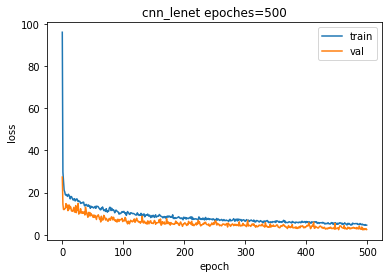

In [16]:
plt.plot(history_lenet.history['loss'])
plt.plot(history_lenet.history['val_loss'])
plt.title('cnn_lenet epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [17]:
#``mlp4`` from the tf_models module
model_mlp4 = mlp4(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_mlp4.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_mlp4 = model_mlp4.fit(train_dataset, epochs=500, validation_data=val_dataset)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 flatten_2 (Flatten)         (None, 4800)              0         
                                                                 
 dropout_4 (Dropout)         (None, 4800)              0         
                                                                 
 dense_6 (Dense)             (None, 500)               2400500   
                                                                 
 dropout_5 (Dropout)         (None, 500)               0         
                                                                 
 dense_7 (Dense)             (None, 500)               250500    
                                                                 
 dropout_6 (Dropout)         (None, 500)               0   

Epoch 40/500
11/11 [==============================] - 0s 22ms/step - loss: 9.6060 - mean_squared_error: 9.6060 - val_loss: 8.7532 - val_mean_squared_error: 8.7532
Epoch 41/500
11/11 [==============================] - 0s 21ms/step - loss: 9.8412 - mean_squared_error: 9.8412 - val_loss: 8.0632 - val_mean_squared_error: 8.0632
Epoch 42/500
11/11 [==============================] - 0s 22ms/step - loss: 9.7478 - mean_squared_error: 9.7478 - val_loss: 7.0305 - val_mean_squared_error: 7.0305
Epoch 43/500
11/11 [==============================] - 0s 21ms/step - loss: 9.1042 - mean_squared_error: 9.1042 - val_loss: 10.0850 - val_mean_squared_error: 10.0850
Epoch 44/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9998 - mean_squared_error: 8.9998 - val_loss: 12.4815 - val_mean_squared_error: 12.4815
Epoch 45/500
11/11 [==============================] - 0s 21ms/step - loss: 11.5003 - mean_squared_error: 11.5003 - val_loss: 7.7174 - val_mean_squared_error: 7.7174
Epoch 46/500
11/

Epoch 90/500
11/11 [==============================] - 0s 21ms/step - loss: 13.2262 - mean_squared_error: 13.2262 - val_loss: 9.4706 - val_mean_squared_error: 9.4706
Epoch 91/500
11/11 [==============================] - 0s 21ms/step - loss: 11.3752 - mean_squared_error: 11.3752 - val_loss: 12.2720 - val_mean_squared_error: 12.2720
Epoch 92/500
11/11 [==============================] - 0s 21ms/step - loss: 9.5942 - mean_squared_error: 9.5942 - val_loss: 10.0729 - val_mean_squared_error: 10.0729
Epoch 93/500
11/11 [==============================] - 0s 21ms/step - loss: 9.9194 - mean_squared_error: 9.9194 - val_loss: 11.5511 - val_mean_squared_error: 11.5511
Epoch 94/500
11/11 [==============================] - 0s 21ms/step - loss: 9.7325 - mean_squared_error: 9.7325 - val_loss: 10.8432 - val_mean_squared_error: 10.8432
Epoch 95/500
11/11 [==============================] - 0s 22ms/step - loss: 9.1747 - mean_squared_error: 9.1747 - val_loss: 11.5849 - val_mean_squared_error: 11.5849
Epoch 96

Epoch 140/500
11/11 [==============================] - 0s 21ms/step - loss: 8.8903 - mean_squared_error: 8.8903 - val_loss: 8.2105 - val_mean_squared_error: 8.2105
Epoch 141/500
11/11 [==============================] - 0s 25ms/step - loss: 8.2094 - mean_squared_error: 8.2094 - val_loss: 11.4963 - val_mean_squared_error: 11.4963
Epoch 142/500
11/11 [==============================] - 0s 24ms/step - loss: 9.1824 - mean_squared_error: 9.1824 - val_loss: 7.6333 - val_mean_squared_error: 7.6333
Epoch 143/500
11/11 [==============================] - 0s 22ms/step - loss: 8.5691 - mean_squared_error: 8.5691 - val_loss: 9.2552 - val_mean_squared_error: 9.2552
Epoch 144/500
11/11 [==============================] - 0s 24ms/step - loss: 8.8777 - mean_squared_error: 8.8777 - val_loss: 16.7849 - val_mean_squared_error: 16.7849
Epoch 145/500
11/11 [==============================] - 0s 24ms/step - loss: 9.2809 - mean_squared_error: 9.2809 - val_loss: 14.1439 - val_mean_squared_error: 14.1439
Epoch 146/

Epoch 190/500
11/11 [==============================] - 0s 21ms/step - loss: 9.7738 - mean_squared_error: 9.7738 - val_loss: 9.1519 - val_mean_squared_error: 9.1519
Epoch 191/500
11/11 [==============================] - 0s 21ms/step - loss: 9.7478 - mean_squared_error: 9.7478 - val_loss: 7.6342 - val_mean_squared_error: 7.6342
Epoch 192/500
11/11 [==============================] - 0s 21ms/step - loss: 9.6629 - mean_squared_error: 9.6629 - val_loss: 10.2007 - val_mean_squared_error: 10.2007
Epoch 193/500
11/11 [==============================] - 0s 22ms/step - loss: 8.6810 - mean_squared_error: 8.6810 - val_loss: 11.8493 - val_mean_squared_error: 11.8493
Epoch 194/500
11/11 [==============================] - 0s 21ms/step - loss: 9.2213 - mean_squared_error: 9.2213 - val_loss: 8.6605 - val_mean_squared_error: 8.6605
Epoch 195/500
11/11 [==============================] - 0s 22ms/step - loss: 8.6921 - mean_squared_error: 8.6921 - val_loss: 7.8506 - val_mean_squared_error: 7.8506
Epoch 196/50

Epoch 240/500
11/11 [==============================] - 0s 21ms/step - loss: 8.5679 - mean_squared_error: 8.5679 - val_loss: 8.9566 - val_mean_squared_error: 8.9566
Epoch 241/500
11/11 [==============================] - 0s 22ms/step - loss: 8.4220 - mean_squared_error: 8.4220 - val_loss: 10.3618 - val_mean_squared_error: 10.3618
Epoch 242/500
11/11 [==============================] - 0s 22ms/step - loss: 8.1509 - mean_squared_error: 8.1509 - val_loss: 11.5576 - val_mean_squared_error: 11.5576
Epoch 243/500
11/11 [==============================] - 0s 22ms/step - loss: 9.1724 - mean_squared_error: 9.1724 - val_loss: 16.3502 - val_mean_squared_error: 16.3502
Epoch 244/500
11/11 [==============================] - 0s 21ms/step - loss: 9.1959 - mean_squared_error: 9.1959 - val_loss: 8.5240 - val_mean_squared_error: 8.5240
Epoch 245/500
11/11 [==============================] - 0s 22ms/step - loss: 8.7498 - mean_squared_error: 8.7498 - val_loss: 7.9793 - val_mean_squared_error: 7.9793
Epoch 246/

Epoch 290/500
11/11 [==============================] - 0s 21ms/step - loss: 8.7374 - mean_squared_error: 8.7374 - val_loss: 7.6102 - val_mean_squared_error: 7.6102
Epoch 291/500
11/11 [==============================] - 0s 21ms/step - loss: 8.7436 - mean_squared_error: 8.7436 - val_loss: 11.9832 - val_mean_squared_error: 11.9832
Epoch 292/500
11/11 [==============================] - 0s 21ms/step - loss: 10.3711 - mean_squared_error: 10.3711 - val_loss: 7.4344 - val_mean_squared_error: 7.4344
Epoch 293/500
11/11 [==============================] - 0s 21ms/step - loss: 9.6266 - mean_squared_error: 9.6266 - val_loss: 11.2092 - val_mean_squared_error: 11.2092
Epoch 294/500
11/11 [==============================] - 0s 21ms/step - loss: 8.7348 - mean_squared_error: 8.7348 - val_loss: 9.3710 - val_mean_squared_error: 9.3710
Epoch 295/500
11/11 [==============================] - 0s 21ms/step - loss: 9.5403 - mean_squared_error: 9.5403 - val_loss: 8.2989 - val_mean_squared_error: 8.2989
Epoch 296/

Epoch 340/500
11/11 [==============================] - 0s 22ms/step - loss: 8.7571 - mean_squared_error: 8.7571 - val_loss: 9.6877 - val_mean_squared_error: 9.6877
Epoch 341/500
11/11 [==============================] - 0s 23ms/step - loss: 8.4335 - mean_squared_error: 8.4335 - val_loss: 6.6990 - val_mean_squared_error: 6.6990
Epoch 342/500
11/11 [==============================] - 0s 22ms/step - loss: 8.9298 - mean_squared_error: 8.9298 - val_loss: 9.7291 - val_mean_squared_error: 9.7291
Epoch 343/500
11/11 [==============================] - 0s 23ms/step - loss: 8.9734 - mean_squared_error: 8.9734 - val_loss: 10.7294 - val_mean_squared_error: 10.7294
Epoch 344/500
11/11 [==============================] - 0s 23ms/step - loss: 8.9264 - mean_squared_error: 8.9264 - val_loss: 6.8976 - val_mean_squared_error: 6.8976
Epoch 345/500
11/11 [==============================] - 0s 24ms/step - loss: 9.2655 - mean_squared_error: 9.2655 - val_loss: 12.6218 - val_mean_squared_error: 12.6218
Epoch 346/50

Epoch 390/500
11/11 [==============================] - 0s 21ms/step - loss: 9.1217 - mean_squared_error: 9.1217 - val_loss: 7.6970 - val_mean_squared_error: 7.6970
Epoch 391/500
11/11 [==============================] - 0s 22ms/step - loss: 8.8515 - mean_squared_error: 8.8515 - val_loss: 8.4273 - val_mean_squared_error: 8.4273
Epoch 392/500
11/11 [==============================] - 0s 21ms/step - loss: 8.9614 - mean_squared_error: 8.9614 - val_loss: 11.1231 - val_mean_squared_error: 11.1231
Epoch 393/500
11/11 [==============================] - 0s 22ms/step - loss: 9.4841 - mean_squared_error: 9.4841 - val_loss: 7.9797 - val_mean_squared_error: 7.9797
Epoch 394/500
11/11 [==============================] - 0s 21ms/step - loss: 8.9608 - mean_squared_error: 8.9608 - val_loss: 7.8898 - val_mean_squared_error: 7.8898
Epoch 395/500
11/11 [==============================] - 0s 21ms/step - loss: 9.2223 - mean_squared_error: 9.2223 - val_loss: 11.0918 - val_mean_squared_error: 11.0918
Epoch 396/50

Epoch 440/500
11/11 [==============================] - 0s 22ms/step - loss: 8.5515 - mean_squared_error: 8.5515 - val_loss: 11.1333 - val_mean_squared_error: 11.1333
Epoch 441/500
11/11 [==============================] - 0s 21ms/step - loss: 8.5486 - mean_squared_error: 8.5486 - val_loss: 11.0159 - val_mean_squared_error: 11.0159
Epoch 442/500
11/11 [==============================] - 0s 21ms/step - loss: 8.4979 - mean_squared_error: 8.4979 - val_loss: 11.2976 - val_mean_squared_error: 11.2976
Epoch 443/500
11/11 [==============================] - 0s 21ms/step - loss: 8.2499 - mean_squared_error: 8.2499 - val_loss: 6.1397 - val_mean_squared_error: 6.1397
Epoch 444/500
11/11 [==============================] - 0s 21ms/step - loss: 8.7823 - mean_squared_error: 8.7823 - val_loss: 12.9739 - val_mean_squared_error: 12.9739
Epoch 445/500
11/11 [==============================] - 0s 21ms/step - loss: 8.7450 - mean_squared_error: 8.7450 - val_loss: 9.9294 - val_mean_squared_error: 9.9294
Epoch 44

Epoch 490/500
11/11 [==============================] - 0s 21ms/step - loss: 10.0967 - mean_squared_error: 10.0967 - val_loss: 7.1534 - val_mean_squared_error: 7.1534
Epoch 491/500
11/11 [==============================] - 0s 22ms/step - loss: 8.7905 - mean_squared_error: 8.7905 - val_loss: 6.8287 - val_mean_squared_error: 6.8287
Epoch 492/500
11/11 [==============================] - 0s 22ms/step - loss: 8.4840 - mean_squared_error: 8.4840 - val_loss: 11.6382 - val_mean_squared_error: 11.6382
Epoch 493/500
11/11 [==============================] - 0s 21ms/step - loss: 9.1173 - mean_squared_error: 9.1173 - val_loss: 8.3644 - val_mean_squared_error: 8.3644
Epoch 494/500
11/11 [==============================] - 0s 21ms/step - loss: 8.6156 - mean_squared_error: 8.6156 - val_loss: 9.1874 - val_mean_squared_error: 9.1874
Epoch 495/500
11/11 [==============================] - 0s 21ms/step - loss: 8.7952 - mean_squared_error: 8.7952 - val_loss: 12.1225 - val_mean_squared_error: 12.1225
Epoch 496/

In [18]:
# Evaluate the model on the validation set
eval_mlp4 = model_mlp4.evaluate(val_dataset)
# update the result
results.update({'mlp4': eval_mlp4})

3/3 [==============================] - 0s 15ms/step - loss: 6.6919 - mean_squared_error: 6.6919


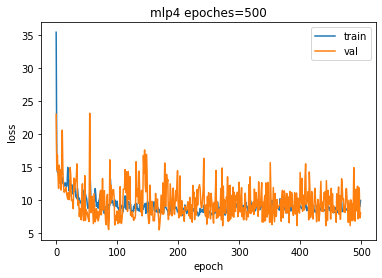

In [19]:
plt.plot(history_mlp4.history['loss'])
plt.plot(history_mlp4.history['val_loss'])
plt.title('mlp4 epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [20]:
#``cnn_vgg`` from the tf_models module
model_cnn_vgg= cnn_vgg(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_cnn_vgg.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_vgg = model_cnn_vgg.fit(train_dataset, epochs=500, validation_data=val_dataset)

pooling layers: 4
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 100, 64)           9280      
                                                                 
 conv1d_9 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 50, 128)           24704     
                                                                 
 conv1d_11 (Conv1D)          (None, 50, 128)           49280     
                                         

11/11 [==============================] - 5s 446ms/step - loss: 3.1807 - mean_squared_error: 3.1807 - val_loss: 2.0814 - val_mean_squared_error: 2.0814
Epoch 80/500
11/11 [==============================] - 5s 443ms/step - loss: 2.5806 - mean_squared_error: 2.5806 - val_loss: 2.7714 - val_mean_squared_error: 2.7714
Epoch 81/500
11/11 [==============================] - 5s 447ms/step - loss: 3.3523 - mean_squared_error: 3.3523 - val_loss: 1.7705 - val_mean_squared_error: 1.7705
Epoch 82/500
11/11 [==============================] - 5s 484ms/step - loss: 2.9868 - mean_squared_error: 2.9868 - val_loss: 1.9890 - val_mean_squared_error: 1.9890
Epoch 83/500
11/11 [==============================] - 5s 452ms/step - loss: 2.2864 - mean_squared_error: 2.2864 - val_loss: 1.5235 - val_mean_squared_error: 1.5235
Epoch 84/500
11/11 [==============================] - 5s 459ms/step - loss: 2.0314 - mean_squared_error: 2.0314 - val_loss: 2.0558 - val_mean_squared_error: 2.0558
Epoch 85/500
11/11 [=========

Epoch 129/500
11/11 [==============================] - 5s 446ms/step - loss: 1.2946 - mean_squared_error: 1.2946 - val_loss: 0.5559 - val_mean_squared_error: 0.5559
Epoch 130/500
11/11 [==============================] - 5s 447ms/step - loss: 0.9476 - mean_squared_error: 0.9476 - val_loss: 0.3480 - val_mean_squared_error: 0.3480
Epoch 131/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8757 - mean_squared_error: 0.8757 - val_loss: 0.5248 - val_mean_squared_error: 0.5248
Epoch 132/500
11/11 [==============================] - 5s 443ms/step - loss: 0.9070 - mean_squared_error: 0.9070 - val_loss: 0.4769 - val_mean_squared_error: 0.4769
Epoch 133/500
11/11 [==============================] - 5s 469ms/step - loss: 0.8448 - mean_squared_error: 0.8448 - val_loss: 0.4506 - val_mean_squared_error: 0.4506
Epoch 134/500
11/11 [==============================] - 5s 461ms/step - loss: 0.9293 - mean_squared_error: 0.9293 - val_loss: 0.5838 - val_mean_squared_error: 0.5838
Epoch 135/

Epoch 179/500
11/11 [==============================] - 5s 454ms/step - loss: 1.0922 - mean_squared_error: 1.0922 - val_loss: 0.9865 - val_mean_squared_error: 0.9865
Epoch 180/500
11/11 [==============================] - 5s 450ms/step - loss: 1.2170 - mean_squared_error: 1.2170 - val_loss: 0.5719 - val_mean_squared_error: 0.5719
Epoch 181/500
11/11 [==============================] - 5s 455ms/step - loss: 0.9062 - mean_squared_error: 0.9062 - val_loss: 0.4104 - val_mean_squared_error: 0.4104
Epoch 182/500
11/11 [==============================] - 5s 454ms/step - loss: 0.7689 - mean_squared_error: 0.7689 - val_loss: 0.4039 - val_mean_squared_error: 0.4039
Epoch 183/500
11/11 [==============================] - 5s 467ms/step - loss: 0.7993 - mean_squared_error: 0.7993 - val_loss: 0.3314 - val_mean_squared_error: 0.3314
Epoch 184/500
11/11 [==============================] - 5s 461ms/step - loss: 0.8601 - mean_squared_error: 0.8601 - val_loss: 0.3855 - val_mean_squared_error: 0.3855
Epoch 185/

Epoch 229/500
11/11 [==============================] - 5s 448ms/step - loss: 0.8020 - mean_squared_error: 0.8020 - val_loss: 0.4138 - val_mean_squared_error: 0.4138
Epoch 230/500
11/11 [==============================] - 5s 443ms/step - loss: 0.8635 - mean_squared_error: 0.8635 - val_loss: 0.7948 - val_mean_squared_error: 0.7948
Epoch 231/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8963 - mean_squared_error: 0.8963 - val_loss: 0.3287 - val_mean_squared_error: 0.3287
Epoch 232/500
11/11 [==============================] - 5s 444ms/step - loss: 0.8654 - mean_squared_error: 0.8654 - val_loss: 0.3929 - val_mean_squared_error: 0.3929
Epoch 233/500
11/11 [==============================] - 5s 443ms/step - loss: 0.8139 - mean_squared_error: 0.8139 - val_loss: 0.5352 - val_mean_squared_error: 0.5352
Epoch 234/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8113 - mean_squared_error: 0.8113 - val_loss: 0.3851 - val_mean_squared_error: 0.3851
Epoch 235/

Epoch 279/500
11/11 [==============================] - 5s 440ms/step - loss: 0.7109 - mean_squared_error: 0.7109 - val_loss: 0.1941 - val_mean_squared_error: 0.1941
Epoch 280/500
11/11 [==============================] - 5s 450ms/step - loss: 0.6819 - mean_squared_error: 0.6819 - val_loss: 0.3665 - val_mean_squared_error: 0.3665
Epoch 281/500
11/11 [==============================] - 5s 445ms/step - loss: 0.7109 - mean_squared_error: 0.7109 - val_loss: 0.3162 - val_mean_squared_error: 0.3162
Epoch 282/500
11/11 [==============================] - 5s 444ms/step - loss: 0.6963 - mean_squared_error: 0.6963 - val_loss: 0.3313 - val_mean_squared_error: 0.3313
Epoch 283/500
11/11 [==============================] - 5s 446ms/step - loss: 0.6066 - mean_squared_error: 0.6066 - val_loss: 0.3448 - val_mean_squared_error: 0.3448
Epoch 284/500
11/11 [==============================] - 5s 449ms/step - loss: 0.6748 - mean_squared_error: 0.6748 - val_loss: 0.2395 - val_mean_squared_error: 0.2395
Epoch 285/

Epoch 329/500
11/11 [==============================] - 5s 445ms/step - loss: 0.8117 - mean_squared_error: 0.8117 - val_loss: 0.2511 - val_mean_squared_error: 0.2511
Epoch 330/500
11/11 [==============================] - 5s 447ms/step - loss: 0.6998 - mean_squared_error: 0.6998 - val_loss: 0.7767 - val_mean_squared_error: 0.7767
Epoch 331/500
11/11 [==============================] - 5s 447ms/step - loss: 0.9410 - mean_squared_error: 0.9410 - val_loss: 0.4376 - val_mean_squared_error: 0.4376
Epoch 332/500
11/11 [==============================] - 5s 441ms/step - loss: 1.0218 - mean_squared_error: 1.0218 - val_loss: 0.6471 - val_mean_squared_error: 0.6471
Epoch 333/500
11/11 [==============================] - 5s 447ms/step - loss: 0.9983 - mean_squared_error: 0.9983 - val_loss: 0.5348 - val_mean_squared_error: 0.5348
Epoch 334/500
11/11 [==============================] - 5s 442ms/step - loss: 0.8866 - mean_squared_error: 0.8866 - val_loss: 0.6833 - val_mean_squared_error: 0.6833
Epoch 335/

Epoch 379/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5997 - mean_squared_error: 0.5997 - val_loss: 0.1893 - val_mean_squared_error: 0.1893
Epoch 380/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5634 - mean_squared_error: 0.5634 - val_loss: 0.3129 - val_mean_squared_error: 0.3129
Epoch 381/500
11/11 [==============================] - 5s 441ms/step - loss: 0.5409 - mean_squared_error: 0.5409 - val_loss: 0.2248 - val_mean_squared_error: 0.2248
Epoch 382/500
11/11 [==============================] - 5s 442ms/step - loss: 0.5564 - mean_squared_error: 0.5564 - val_loss: 0.2329 - val_mean_squared_error: 0.2329
Epoch 383/500
11/11 [==============================] - 5s 444ms/step - loss: 0.5242 - mean_squared_error: 0.5242 - val_loss: 0.1847 - val_mean_squared_error: 0.1847
Epoch 384/500
11/11 [==============================] - 5s 442ms/step - loss: 0.5494 - mean_squared_error: 0.5494 - val_loss: 0.3282 - val_mean_squared_error: 0.3282
Epoch 385/

Epoch 429/500
11/11 [==============================] - 5s 447ms/step - loss: 0.8436 - mean_squared_error: 0.8436 - val_loss: 0.4712 - val_mean_squared_error: 0.4712
Epoch 430/500
11/11 [==============================] - 5s 446ms/step - loss: 0.6412 - mean_squared_error: 0.6412 - val_loss: 0.3100 - val_mean_squared_error: 0.3100
Epoch 431/500
11/11 [==============================] - 5s 445ms/step - loss: 0.6037 - mean_squared_error: 0.6037 - val_loss: 0.4263 - val_mean_squared_error: 0.4263
Epoch 432/500
11/11 [==============================] - 5s 456ms/step - loss: 0.6556 - mean_squared_error: 0.6556 - val_loss: 0.2842 - val_mean_squared_error: 0.2842
Epoch 433/500
11/11 [==============================] - 5s 464ms/step - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.3063 - val_mean_squared_error: 0.3063
Epoch 434/500
11/11 [==============================] - 5s 453ms/step - loss: 0.6721 - mean_squared_error: 0.6721 - val_loss: 0.2627 - val_mean_squared_error: 0.2627
Epoch 435/

Epoch 479/500
11/11 [==============================] - 5s 465ms/step - loss: 0.6216 - mean_squared_error: 0.6216 - val_loss: 0.3261 - val_mean_squared_error: 0.3261
Epoch 480/500
11/11 [==============================] - 5s 468ms/step - loss: 0.5258 - mean_squared_error: 0.5258 - val_loss: 0.3777 - val_mean_squared_error: 0.3777
Epoch 481/500
11/11 [==============================] - 5s 450ms/step - loss: 0.4729 - mean_squared_error: 0.4729 - val_loss: 0.3052 - val_mean_squared_error: 0.3052
Epoch 482/500
11/11 [==============================] - 5s 459ms/step - loss: 0.5753 - mean_squared_error: 0.5753 - val_loss: 0.2415 - val_mean_squared_error: 0.2415
Epoch 483/500
11/11 [==============================] - 5s 481ms/step - loss: 0.5281 - mean_squared_error: 0.5281 - val_loss: 0.2363 - val_mean_squared_error: 0.2363
Epoch 484/500
11/11 [==============================] - 5s 475ms/step - loss: 0.5714 - mean_squared_error: 0.5714 - val_loss: 0.4640 - val_mean_squared_error: 0.4640
Epoch 485/

In [21]:
# Evaluate the model on the validation set
eval_cnn_vgg = model_cnn_vgg.evaluate(val_dataset)
# update the result
results.update({'cnn_vgg': eval_cnn_vgg})

3/3 [==============================] - 0s 55ms/step - loss: 0.4727 - mean_squared_error: 0.4727


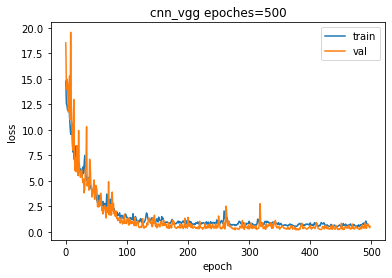

In [34]:
plt.plot(history_vgg.history['loss'][5:])
plt.plot(history_vgg.history['val_loss'][1:])
plt.title('cnn_vgg epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [28]:
#``lstm1v0`` from the tf_models module
model_lstm1v0= lstm1v0(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile themodel and fit it using training data
model_lstm1v0.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_lstm1v0 = model_lstm1v0.fit(train_dataset, epochs=500, validation_data=val_dataset)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 48)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               59600     
                                                                 
 dense_14 (Dense)            (None, 1)                 101       
                                                                 
Total params: 59,701
Trainable params: 59,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [==============================] - 3s 137ms/step - loss: 89.3724 - mean_squared_error: 89.3724 - val_loss: 46.5082 - val_mean_squared_error: 46.5082
Epoch 2/500
11/11 [==============================] - 1s 109ms/step - loss: 27.1202 - mean_squared_error: 27.1202 - val_loss: 14.2640 - val_mean_squared_

Epoch 45/500
11/11 [==============================] - 1s 114ms/step - loss: 12.4367 - mean_squared_error: 12.4367 - val_loss: 12.4617 - val_mean_squared_error: 12.4617
Epoch 46/500
11/11 [==============================] - 1s 109ms/step - loss: 13.0572 - mean_squared_error: 13.0572 - val_loss: 13.5402 - val_mean_squared_error: 13.5402
Epoch 47/500
11/11 [==============================] - 1s 115ms/step - loss: 11.9993 - mean_squared_error: 11.9993 - val_loss: 13.8381 - val_mean_squared_error: 13.8381
Epoch 48/500
11/11 [==============================] - 1s 116ms/step - loss: 12.8566 - mean_squared_error: 12.8566 - val_loss: 13.6488 - val_mean_squared_error: 13.6488
Epoch 49/500
11/11 [==============================] - 1s 109ms/step - loss: 12.2724 - mean_squared_error: 12.2724 - val_loss: 11.6725 - val_mean_squared_error: 11.6725
Epoch 50/500
11/11 [==============================] - 1s 109ms/step - loss: 12.7718 - mean_squared_error: 12.7718 - val_loss: 13.1271 - val_mean_squared_error: 

Epoch 94/500
11/11 [==============================] - 1s 110ms/step - loss: 12.6673 - mean_squared_error: 12.6673 - val_loss: 12.8127 - val_mean_squared_error: 12.8127
Epoch 95/500
11/11 [==============================] - 1s 108ms/step - loss: 12.9870 - mean_squared_error: 12.9870 - val_loss: 13.6870 - val_mean_squared_error: 13.6870
Epoch 96/500
11/11 [==============================] - 1s 109ms/step - loss: 12.4407 - mean_squared_error: 12.4407 - val_loss: 11.0756 - val_mean_squared_error: 11.0756
Epoch 97/500
11/11 [==============================] - 1s 108ms/step - loss: 12.6800 - mean_squared_error: 12.6800 - val_loss: 12.8281 - val_mean_squared_error: 12.8281
Epoch 98/500
11/11 [==============================] - 1s 106ms/step - loss: 12.8232 - mean_squared_error: 12.8232 - val_loss: 12.7930 - val_mean_squared_error: 12.7930
Epoch 99/500
11/11 [==============================] - 1s 108ms/step - loss: 12.3884 - mean_squared_error: 12.3884 - val_loss: 12.6539 - val_mean_squared_error: 

11/11 [==============================] - 1s 109ms/step - loss: 12.9129 - mean_squared_error: 12.9129 - val_loss: 13.5974 - val_mean_squared_error: 13.5974
Epoch 191/500
11/11 [==============================] - 1s 106ms/step - loss: 12.5828 - mean_squared_error: 12.5828 - val_loss: 13.5817 - val_mean_squared_error: 13.5817
Epoch 192/500
11/11 [==============================] - 1s 108ms/step - loss: 12.7813 - mean_squared_error: 12.7813 - val_loss: 11.1819 - val_mean_squared_error: 11.1819
Epoch 193/500
11/11 [==============================] - 1s 106ms/step - loss: 12.5395 - mean_squared_error: 12.5395 - val_loss: 11.7204 - val_mean_squared_error: 11.7204
Epoch 194/500
11/11 [==============================] - 1s 107ms/step - loss: 12.1391 - mean_squared_error: 12.1391 - val_loss: 12.7584 - val_mean_squared_error: 12.7584
Epoch 195/500
11/11 [==============================] - 1s 105ms/step - loss: 13.0779 - mean_squared_error: 13.0779 - val_loss: 12.7878 - val_mean_squared_error: 12.7878


11/11 [==============================] - 1s 106ms/step - loss: 12.4444 - mean_squared_error: 12.4444 - val_loss: 13.1533 - val_mean_squared_error: 13.1533
Epoch 287/500
11/11 [==============================] - 1s 106ms/step - loss: 12.5801 - mean_squared_error: 12.5801 - val_loss: 12.1283 - val_mean_squared_error: 12.1283
Epoch 288/500
11/11 [==============================] - 1s 106ms/step - loss: 12.7041 - mean_squared_error: 12.7041 - val_loss: 11.8774 - val_mean_squared_error: 11.8774
Epoch 289/500
11/11 [==============================] - 1s 107ms/step - loss: 12.3406 - mean_squared_error: 12.3406 - val_loss: 11.6819 - val_mean_squared_error: 11.6819
Epoch 290/500
11/11 [==============================] - 1s 110ms/step - loss: 12.5823 - mean_squared_error: 12.5823 - val_loss: 12.7699 - val_mean_squared_error: 12.7699
Epoch 291/500
11/11 [==============================] - 1s 109ms/step - loss: 12.5066 - mean_squared_error: 12.5066 - val_loss: 12.0175 - val_mean_squared_error: 12.0175


Epoch 383/500
11/11 [==============================] - 1s 108ms/step - loss: 9.5407 - mean_squared_error: 9.5407 - val_loss: 8.9842 - val_mean_squared_error: 8.9842
Epoch 384/500
11/11 [==============================] - 1s 109ms/step - loss: 9.4025 - mean_squared_error: 9.4025 - val_loss: 9.1175 - val_mean_squared_error: 9.1175
Epoch 385/500
11/11 [==============================] - 1s 107ms/step - loss: 9.4193 - mean_squared_error: 9.4193 - val_loss: 9.3318 - val_mean_squared_error: 9.3318
Epoch 386/500
11/11 [==============================] - 1s 105ms/step - loss: 9.3099 - mean_squared_error: 9.3099 - val_loss: 8.9247 - val_mean_squared_error: 8.9247
Epoch 387/500
11/11 [==============================] - 1s 110ms/step - loss: 9.0846 - mean_squared_error: 9.0846 - val_loss: 9.3771 - val_mean_squared_error: 9.3771
Epoch 388/500
11/11 [==============================] - 1s 105ms/step - loss: 9.6340 - mean_squared_error: 9.6340 - val_loss: 10.1694 - val_mean_squared_error: 10.1694
Epoch 38

Epoch 482/500
11/11 [==============================] - 1s 106ms/step - loss: 9.3054 - mean_squared_error: 9.3054 - val_loss: 8.8654 - val_mean_squared_error: 8.8654
Epoch 483/500
11/11 [==============================] - 1s 105ms/step - loss: 8.5563 - mean_squared_error: 8.5563 - val_loss: 9.2943 - val_mean_squared_error: 9.2943
Epoch 484/500
11/11 [==============================] - 1s 105ms/step - loss: 8.2881 - mean_squared_error: 8.2881 - val_loss: 8.8846 - val_mean_squared_error: 8.8846
Epoch 485/500
11/11 [==============================] - 1s 105ms/step - loss: 8.2002 - mean_squared_error: 8.2002 - val_loss: 7.5965 - val_mean_squared_error: 7.5965
Epoch 486/500
11/11 [==============================] - 1s 104ms/step - loss: 8.1853 - mean_squared_error: 8.1853 - val_loss: 8.0540 - val_mean_squared_error: 8.0540
Epoch 487/500
11/11 [==============================] - 1s 112ms/step - loss: 7.9064 - mean_squared_error: 7.9064 - val_loss: 9.9280 - val_mean_squared_error: 9.9280
Epoch 488/

In [29]:
# Evaluate the model on the validation set
eval_lstm1v0 = model_lstm1v0.evaluate(val_dataset)
# update the result
results.update({'lstm1v0': eval_lstm1v0})

3/3 [==============================] - 0s 28ms/step - loss: 7.7960 - mean_squared_error: 7.7960


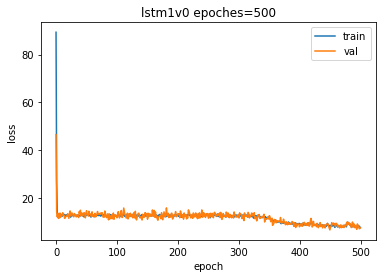

In [30]:
plt.plot(history_lstm1v0.history['loss'])
plt.plot(history_lstm1v0.history['val_loss'])
plt.title('lstm1v0 epoches=500')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [51]:
#``lstm1`` from the tf_models module
model_lstm1= lstm1(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_lstm1.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_lstm1 = model_lstm1.evaluate(val_dataset)
# update the result
results.update({'lstm1': eval_lstm1})

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 100)               59600     
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 59,701
Trainable params: 59,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 3s 150ms/step - loss: 98.7984 - mean_squared_error: 98.7984 - val_loss: 47.9539 - val_mean_squared_error: 47.9539
Epoch 2/100
11/11 [==============================] - 1s 120ms/step - loss: 28.9308 - mean_squared_error: 28.9308 - val_loss: 17.8853 - val_mean_squared

Epoch 45/100
11/11 [==============================] - 1s 110ms/step - loss: 12.7954 - mean_squared_error: 12.7954 - val_loss: 12.0830 - val_mean_squared_error: 12.0830
Epoch 46/100
11/11 [==============================] - 1s 110ms/step - loss: 12.6565 - mean_squared_error: 12.6565 - val_loss: 13.6807 - val_mean_squared_error: 13.6807
Epoch 47/100
11/11 [==============================] - 1s 110ms/step - loss: 12.6624 - mean_squared_error: 12.6624 - val_loss: 12.9925 - val_mean_squared_error: 12.9925
Epoch 48/100
11/11 [==============================] - 1s 109ms/step - loss: 13.5035 - mean_squared_error: 13.5035 - val_loss: 12.5104 - val_mean_squared_error: 12.5104
Epoch 49/100
11/11 [==============================] - 1s 111ms/step - loss: 12.2773 - mean_squared_error: 12.2773 - val_loss: 11.1278 - val_mean_squared_error: 11.1278
Epoch 50/100
11/11 [==============================] - 1s 110ms/step - loss: 12.5880 - mean_squared_error: 12.5880 - val_loss: 14.4573 - val_mean_squared_error: 

Epoch 94/100
11/11 [==============================] - 1s 120ms/step - loss: 12.6770 - mean_squared_error: 12.6770 - val_loss: 12.9918 - val_mean_squared_error: 12.9918
Epoch 95/100
11/11 [==============================] - 1s 117ms/step - loss: 12.7917 - mean_squared_error: 12.7917 - val_loss: 13.7872 - val_mean_squared_error: 13.7872
Epoch 96/100
11/11 [==============================] - 1s 117ms/step - loss: 13.1538 - mean_squared_error: 13.1538 - val_loss: 12.6755 - val_mean_squared_error: 12.6755
Epoch 97/100
11/11 [==============================] - 1s 122ms/step - loss: 12.8723 - mean_squared_error: 12.8723 - val_loss: 12.3312 - val_mean_squared_error: 12.3312
Epoch 98/100
11/11 [==============================] - 1s 121ms/step - loss: 12.5745 - mean_squared_error: 12.5745 - val_loss: 12.3962 - val_mean_squared_error: 12.3962
Epoch 99/100
11/11 [==============================] - 1s 120ms/step - loss: 13.0475 - mean_squared_error: 13.0475 - val_loss: 13.0033 - val_mean_squared_error: 

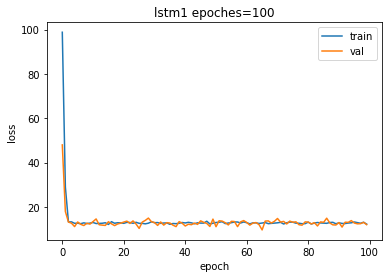

In [52]:
plt.plot(history_lstm1.history['loss'])
plt.plot(history_lstm1.history['val_loss'])
plt.title('lstm1 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [53]:
#``lstm2`` from the tf_models module
model_lstm2= lstm2(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_lstm2.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_lstm2 = model_lstm2.evaluate(val_dataset)
# update the result
results.update({'lstm2': eval_lstm2})

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 lstm_6 (LSTM)               (None, 100, 100)          59600     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 140,101
Trainable params: 140,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 6s 297ms/step - loss: 81.1756 - mean_squared_error: 81.1756 - val_loss: 21.8543 - val_mean_squared_error: 21.8543
Epoch 2/100
11/11

Epoch 93/100
11/11 [==============================] - 3s 234ms/step - loss: 12.6825 - mean_squared_error: 12.6825 - val_loss: 12.9027 - val_mean_squared_error: 12.9027
Epoch 94/100
11/11 [==============================] - 3s 232ms/step - loss: 12.7125 - mean_squared_error: 12.7125 - val_loss: 13.4282 - val_mean_squared_error: 13.4282
Epoch 95/100
11/11 [==============================] - 3s 232ms/step - loss: 12.4079 - mean_squared_error: 12.4079 - val_loss: 12.8691 - val_mean_squared_error: 12.8691
Epoch 96/100
11/11 [==============================] - 3s 231ms/step - loss: 12.1852 - mean_squared_error: 12.1852 - val_loss: 12.0114 - val_mean_squared_error: 12.0114
Epoch 97/100
11/11 [==============================] - 3s 230ms/step - loss: 12.4746 - mean_squared_error: 12.4746 - val_loss: 12.3874 - val_mean_squared_error: 12.3874
Epoch 98/100
11/11 [==============================] - 3s 231ms/step - loss: 12.7008 - mean_squared_error: 12.7008 - val_loss: 13.1632 - val_mean_squared_error: 

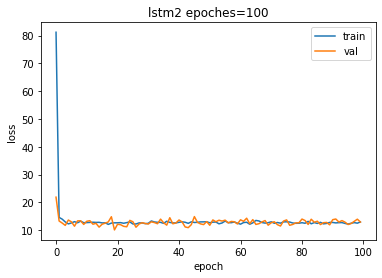

In [54]:
plt.plot(history_lstm2.history['loss'])
plt.plot(history_lstm2.history['val_loss'])
plt.title('lstm2 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [55]:
#``blstm1`` from the tf_models module
model_blstm1= blstm1(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_blstm1.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_blstm1 = model_blstm1.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_blstm1 = model_blstm1.evaluate(val_dataset)
# update the result
results.update({'blstm1': eval_blstm1})

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              119200    
 l)                                                              
                                                                 
 dense_34 (Dense)            (None, 1)                 201       
                                                                 
Total params: 119,401
Trainable params: 119,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 5s 248ms/step - loss: 78.2261 - mean_squared_error: 78.2261 - val_loss: 24.3760 - val_mean_squared_error: 24.3760
Epoch 2/100
11/11 [==============================] - 2s 181ms/step - loss: 16.5562 

Epoch 93/100
11/11 [==============================] - 2s 185ms/step - loss: 12.2642 - mean_squared_error: 12.2642 - val_loss: 12.7391 - val_mean_squared_error: 12.7391
Epoch 94/100
11/11 [==============================] - 2s 192ms/step - loss: 13.0452 - mean_squared_error: 13.0452 - val_loss: 12.5524 - val_mean_squared_error: 12.5524
Epoch 95/100
11/11 [==============================] - 2s 174ms/step - loss: 12.8895 - mean_squared_error: 12.8895 - val_loss: 13.1975 - val_mean_squared_error: 13.1975
Epoch 96/100
11/11 [==============================] - 2s 174ms/step - loss: 13.0615 - mean_squared_error: 13.0615 - val_loss: 12.2372 - val_mean_squared_error: 12.2372
Epoch 97/100
11/11 [==============================] - 2s 168ms/step - loss: 12.7700 - mean_squared_error: 12.7700 - val_loss: 13.8083 - val_mean_squared_error: 13.8083
Epoch 98/100
11/11 [==============================] - 2s 181ms/step - loss: 12.6981 - mean_squared_error: 12.6981 - val_loss: 11.0075 - val_mean_squared_error: 

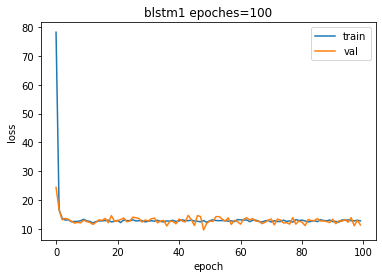

In [56]:
plt.plot(history_blstm1.history['loss'])
plt.plot(history_blstm1.history['val_loss'])
plt.title('blstm1 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [61]:
#``blstm2`` from the tf_models module
model_blstm2= blstm2(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_blstm2.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_blstm2 = model_blstm2.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_blstm2 = model_blstm2.evaluate(val_dataset)
# update the result
results.update({'blstm2': eval_blstm2})

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100, 48)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 200)         119200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_41 (Dense)            (None, 1)                 201       
                                                                 
Total params: 360,201
Trainable params: 360,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] -

Epoch 92/100
11/11 [==============================] - 6s 504ms/step - loss: 12.3139 - mean_squared_error: 12.3139 - val_loss: 12.2441 - val_mean_squared_error: 12.2441
Epoch 93/100
11/11 [==============================] - 5s 449ms/step - loss: 12.7356 - mean_squared_error: 12.7356 - val_loss: 11.3083 - val_mean_squared_error: 11.3083
Epoch 94/100
11/11 [==============================] - 5s 456ms/step - loss: 12.4784 - mean_squared_error: 12.4784 - val_loss: 13.0356 - val_mean_squared_error: 13.0356
Epoch 95/100
11/11 [==============================] - 5s 458ms/step - loss: 12.7295 - mean_squared_error: 12.7295 - val_loss: 12.8846 - val_mean_squared_error: 12.8846
Epoch 96/100
11/11 [==============================] - 5s 459ms/step - loss: 13.0571 - mean_squared_error: 13.0571 - val_loss: 12.5685 - val_mean_squared_error: 12.5685
Epoch 97/100
11/11 [==============================] - 5s 468ms/step - loss: 12.7852 - mean_squared_error: 12.7852 - val_loss: 13.4491 - val_mean_squared_error: 

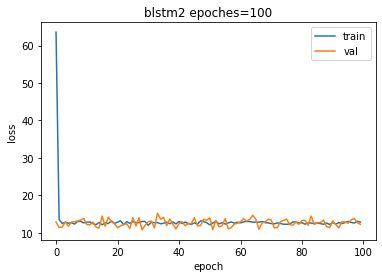

In [62]:
plt.plot(history_blstm2.history['loss'])
plt.plot(history_blstm2.history['val_loss'])
plt.title('blstm2 epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [63]:
#``lstm_fcn`` from the tf_models module
model_lstm_fcn= lstm_fcn(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_lstm_fcn.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_lstm_fcn = model_lstm_fcn.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_lstm_fcn = model_lstm_fcn.evaluate(val_dataset)
# update the result
results.update({'lstm_fcn': eval_lstm_fcn})

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 100, 48)]    0           []                               
                                                                                                  
 conv1d_64 (Conv1D)             (None, 100, 128)     49280       ['input_20[0][0]']               
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 128)    512         ['conv1d_64[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 100, 128)     0           ['batch_normalization[0][0

Epoch 74/100
11/11 [==============================] - 2s 220ms/step - loss: 1.5934 - mean_squared_error: 1.5934 - val_loss: 15.2791 - val_mean_squared_error: 15.2791
Epoch 75/100
11/11 [==============================] - 2s 209ms/step - loss: 1.6555 - mean_squared_error: 1.6555 - val_loss: 25.2340 - val_mean_squared_error: 25.2340
Epoch 76/100
11/11 [==============================] - 2s 212ms/step - loss: 1.8081 - mean_squared_error: 1.8081 - val_loss: 4.6199 - val_mean_squared_error: 4.6199
Epoch 77/100
11/11 [==============================] - 2s 219ms/step - loss: 1.8609 - mean_squared_error: 1.8609 - val_loss: 11.6629 - val_mean_squared_error: 11.6629
Epoch 78/100
11/11 [==============================] - 2s 206ms/step - loss: 1.6378 - mean_squared_error: 1.6378 - val_loss: 16.3617 - val_mean_squared_error: 16.3617
Epoch 79/100
11/11 [==============================] - 3s 237ms/step - loss: 1.4238 - mean_squared_error: 1.4238 - val_loss: 19.9249 - val_mean_squared_error: 19.9249
Epoch 

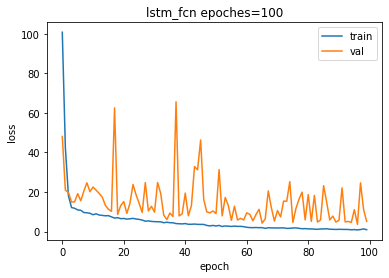

In [64]:
plt.plot(history_lstm_fcn.history['loss'])
plt.plot(history_lstm_fcn.history['val_loss'])
plt.title('lstm_fcn epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [65]:
#``cnn_resnet`` from the tf_models module
model_cnn_resnet= cnn_resnet(input_shape=(100, 48) , n_classes=1, output_activation=None, verbose=True)
# Compile the model and fit it using training data
model_cnn_resnet.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_cnn_resnet = model_cnn_resnet.fit(train_dataset, epochs=100, validation_data=val_dataset)
# Evaluate the model on the validation set
eval_cnn_resnet = model_cnn_resnet.evaluate(val_dataset)
# update the result
results.update({'cnn_resnet': eval_cnn_resnet})

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 100, 48)]    0           []                               
                                                                                                  
 conv1d_67 (Conv1D)             (None, 100, 64)      24640       ['input_21[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 100, 64)     256         ['conv1d_67[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 100, 64)      0           ['batch_normalization_3[0]

11/11 [==============================] - 7s 352ms/step - loss: 91.9775 - mean_squared_error: 91.9775 - val_loss: 145.7154 - val_mean_squared_error: 145.7154
Epoch 2/100
11/11 [==============================] - 4s 326ms/step - loss: 46.8540 - mean_squared_error: 46.8540 - val_loss: 90.4750 - val_mean_squared_error: 90.4750
Epoch 3/100
11/11 [==============================] - 4s 336ms/step - loss: 31.3102 - mean_squared_error: 31.3102 - val_loss: 60.4606 - val_mean_squared_error: 60.4606
Epoch 4/100
11/11 [==============================] - 4s 344ms/step - loss: 20.9390 - mean_squared_error: 20.9390 - val_loss: 27.2250 - val_mean_squared_error: 27.2250
Epoch 5/100
11/11 [==============================] - 4s 339ms/step - loss: 14.0831 - mean_squared_error: 14.0831 - val_loss: 24.0815 - val_mean_squared_error: 24.0815
Epoch 6/100
11/11 [==============================] - 4s 342ms/step - loss: 10.5405 - mean_squared_error: 10.5405 - val_loss: 12.8312 - val_mean_squared_error: 12.8312
Epoch 7/

Epoch 100/100
3/3 [==============================] - 0s 46ms/step - loss: 6.4675 - mean_squared_error: 6.4675


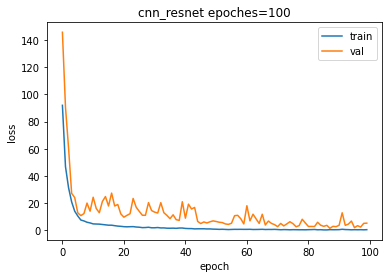

In [66]:
plt.plot(history_cnn_resnet.history['loss'])
plt.plot(history_cnn_resnet.history['val_loss'])
plt.title('cnn_resnet epoches=100')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [68]:
results

{'cnn_lenet': [0.72774338722229, 0.72774338722229],
 'mlp4': [10.9797945022583, 10.9797945022583],
 'lstm1v0': [6.4763503074646, 6.4763503074646],
 'cnn_vgg': [0.7785779237747192, 0.7785779237747192],
 'lstm1': [14.305306434631348, 14.305306434631348],
 'lstm2': [12.756155967712402, 12.756155967712402],
 'blstm1': [12.261481285095215, 12.261481285095215],
 'blstm2': [12.069232940673828, 12.069232940673828],
 'lstm_fcn': [5.095458507537842, 5.095458507537842],
 'cnn_resnet': [6.467532157897949, 6.467532157897949]}